# TD Convolutional Neural Networks

## Objectives

The objective of this class is to
- build from scratch a convolutional neural network (CNN) using PyToch framework for image classification
- develop a transfer learning approach that makes use of a pre-trained model

To make the optimization efficient, we will work with the GPU acceleration provided by Colab.
To set the GPU acceleration:
* Edit
* Notebook settings
* Hardware accelerator: **GPU**


In [ ]:
# Usual libraries
import numpy as np
import time, os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import v2

# scikitlearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Pandas
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Useful if you want to store intermediate results on your drive
from google.colab import drive

drive.mount('/content/gdrive/')
DATA_DIR =  '/content/gdrive/MyDrive/teaching/IOGS/2025'


Mounted at /content/gdrive/


In [ ]:
if torch.cuda.is_available():
  !nvidia-smi

Sat Feb  8 12:53:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# The network

## Architecture

The state of the art for image classification is convolutional neural networks (CNN).
These CNNs have become more and more complex and involve today a high number of convolutional layers.
In this class to keep the optimization possible in the time of the class, we will use a very simple network based on LeNet-5.

<font color='red'>Question</font> Create a network with 3 convolutions and 1 linear layer.

The input will be batches of gray scale images of size $32\times32$, i.e. tensors with dimensions: $\text{batch_size} \times 1 \times 32 \times 32$.

The network will be:
```
conv (3 -> 32, kernel 5x5)
leaky_relu
max_pooling
conv (32 -> 64, kernel 3x3)
leaky_relu
max_pooling
conv (64 -> 64, kernel 3x3)
leaky_relu
Linear (??? -> 10)
```
In the `__init__` function, you need to declare the layers with parameters (convolutional and linear layers).
In the `forward` function, you describe the information flow from the input `(x)` to the final output.

The object with parameters are:
* `nn.Conv2d(a,b,c)` where `a` is the input channel number, `b` the output channel number and `c` the kernel size.
* `nn.Linear(a,b)` where `a` is the input size, `b` the output size

Here are some useful functions:
* `F.leaky_relu(a)`: apply a relu on `a`
* `F.max_pool2d(a,2)`: apply a max pooling of size 2 on `a`
* `b = a.view(a.size(0), -1)`: flattens `a` to be usable with linear layer (shoud be used between 2d operations and 1d operations)

The `pooling` layers are used to subsample the original image by a 2 factor (the `stride` parameter).

One specific difficulty is to compute the input size of the last fully connected layer (the output of flattening step `view`).


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self,n_out=10, n_in=1):
        super().__init__()

        # Put the layers here
        self.conv1 = nn.Conv2d(n_in, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.final = nn.Linear(4096, n_out)

    def forward(self, x):
        # Put the sequence of layer computation here (conv, pooling, activation, linear...)
        # Each step transforms the input as : x = f(x)

        x = F.leaky_relu(self.conv1(x)) ## l'image 1x32x32 devient 32x32x32
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis 32x16x16
        x = F.leaky_relu(self.conv2(x)) ## puis devient 64x16x16
        x = F.max_pool2d(x, kernel_size=2, stride=2) ## puis devient 64x8x8
        x = F.leaky_relu(self.conv3(x)) ## pas de changement

        x = x.view(-1,4096) ## 64x8x8 devient 4096

        x = self.final(x) ## on finit exactement de la même façon

        return x


In [ ]:
# Run this cell to see the whole network parameters
import torchsummary

model = SimpleCNN(n_out=10)
model.to(device)
torchsummary.summary(model, input_size=(1,32,32), batch_size=64)

print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 32, 32]             832
            Conv2d-2           [64, 64, 16, 16]          18,496
            Conv2d-3             [64, 64, 8, 8]          36,928
            Linear-4                   [64, 10]          40,970
Total params: 97,226
Trainable params: 97,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 26.00
Params size (MB): 0.37
Estimated Total Size (MB): 26.63
----------------------------------------------------------------
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (final): Linear(in_features=4096, out_features=10, bias

# The training

## Main optimization loop

This is the main loop for optimization.
It follows the same principles as the MLP of the previous class.

#### Train

- Set the gradients to zero

- Compute the outputs

- Compute the cross entropy loss

- Call backward on the loss (gradient computation)

- Call step on the optimizer

- Update the optimization parameters (scheduler)

- Compute the predictions on the outputs (in
numpy format), it is the argmax of the prediction vector

- Update the confusion matrix

#### Test
- Compute the outputs on validation set

- Compute the predictions on the outputs (in numpy format), it is the argmax of the prediction vector

- Update the confusion matrix

#### Display results
- Compute train and test accuracies, display them

- Save these accuracy in the corresponding lists

#### Misc
Do not forget to put your variables on the GPU with `variable.to(device)`.

In [ ]:
import copy #
from IPython.display import clear_output

## To compute the current error from confusion matrix
def accuracy(cm):
    return cm.trace() / cm.sum()


def train_model_multiclass(model, nlabel, trainloader, valloader,
                           optimizer, scheduler, num_epochs=25, display=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_perf = 0.0

    # list for saving accuracies
    train_perf = []
    test_perf = []
    train_losses = []

    criterion = nn.CrossEntropyLoss()

    # iterate over epochs
    for epoch in range(num_epochs):

        # set the model in train mode
        model.train()

        # create a zero confusion matrix
        cm = np.zeros((nlabel,nlabel))

        running_loss = 0.0

        for inputs, targets in tqdm(trainloader, ncols=80,  desc="Epoch {}".format(epoch)):

            # Put data to GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # gradients to zero
            optimizer.zero_grad()

            # compute outputs
            outputs = model(inputs)

            # compute loss
            loss = criterion(outputs, targets)

            # backward on loss
            loss.backward()
            running_loss += loss.item() * inputs.size(0)

            # optimizer step
            optimizer.step()

            # Transfer data to main CPU and translate tensors to numpy
            outputs_np = outputs.cpu().detach().numpy()
            targets_np = targets.cpu().detach().numpy()

            # compute the predictions
            pred = np.argmax(outputs_np, axis=1)

            # update the perf
            cm = cm + confusion_matrix(targets_np, pred, labels=list(range(nlabel)))

        # set the model to evaluation mode
        model.eval()

        # create the perf
        cm_test = np.zeros((nlabel,nlabel))

        # tell not to reserve memory space for gradients (much faster)
        with torch.no_grad():
            for inputs, targets in tqdm(valloader, ncols=80, desc=" Test {}".format(epoch)):

                # Put data to GPU
                inputs = inputs.to(device)
                targets = targets.to(device)

                # compute outputs
                outputs = model(inputs)

                # Transfer data to main CPU and translate tensors to numpy
                outputs_np = outputs.cpu().detach().numpy()
                targets_np = targets.cpu().detach().numpy()

                # compute the predictions
                pred = np.argmax(outputs_np, axis=1)

                # update the confusion matrix
                cm_test = cm_test + confusion_matrix(targets_np, pred, labels=list(range(nlabel)))

        clear_output()

        # compute accuracies and display them
        oa_train = accuracy(cm)
        oa_test = accuracy(cm_test)
        epoch_loss = running_loss / len(trainloader.dataset)
        print("")
        print("train = {:.2f}%; val = {:.2f}%; loss = {:e}".format(oa_train*100, oa_test*100, epoch_loss))

        # add accuracies to the lists
        train_perf.append(oa_train)
        train_losses.append(epoch_loss)
        test_perf.append(oa_test)

        # Plot the learning curves
        if display:
          plt.plot(train_perf,label='train')
          plt.plot(test_perf,label='test')
          plt.legend()
          plt.show()

        # deep copy the model
        if oa_test > best_perf:
            best_perf = oa_test
            best_model_wts = copy.deepcopy(model.state_dict())

        # learning rate update
        if scheduler is not None: scheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_perf))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # return model and learning curves
    return model, train_perf, test_perf, train_losses


# The data


### Datasets and Dataloaders

PyTorch and TorchVision offer classes for an easy data usage.

The Dataset class contains data and ground truth and applies data transformation such as normalization, resizing or data augmentation when the called.

The DataLoader is an iterator used to sample mini batches in a random way that are fed to the optimization loop.


## CIFAR10 dataset

We will use the classic Cifar10 dataset for image classification which contains small images of objects. It contains RGB images (20000 for training and
10000 for testing) from 10 different classes.



In [ ]:
# Used to resize the data and transform in tensor format
transform_train = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
# Stores the dataset locally
cifartrain = torchvision.datasets.CIFAR10("./cifar10",train=True, transform=transform_train, download=True)
cifartest = torchvision.datasets.CIFAR10("./cifar10",train=False, transform=transform_test, download=True)

class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [ ]:
# Defines the interface that generates random batches of data
trainloader = torch.utils.data.DataLoader(cifartrain, batch_size=256, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(cifartest, batch_size=256, shuffle=False, num_workers=2)

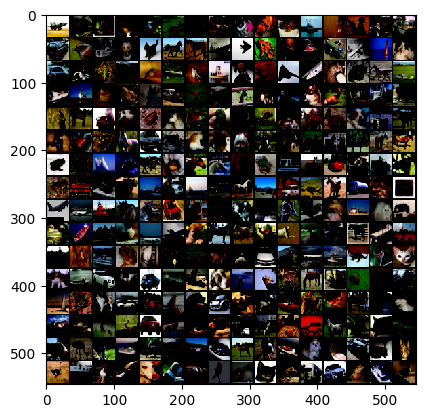

torch.Size([256, 3, 32, 32])


In [ ]:
# Displays a few examples
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

sample,targets = next(iter(trainloader))
show(torchvision.utils.make_grid(sample, nrow=16))
plt.show()

print(sample.shape)  ## 64 c'est le batch
                        ## 1 c'est du gris --  3 pour du RGB
                        ## 32x32 c'est pour la taille de l'image (petite ici)


## The optimisation

Use the function `train_model_multiclass` you have defined previously.

The main ingredient of the optimization is the definition of the learning rate and batch size, which set from the data loader tools.

The following code uses `torch.save` and `torch.load` to save and reload your networks during learning.

<font color='red'>Question</font>  Read and understand the code before running it.

## Network analysis

The learned network can be analyzed to try to understand how it works.

The following code displays two things:
- The convolutional filters
- The outputs of the convolutional filters for a given sample.

<font color='red'>Question</font> Observe the results: what can be deduced from this visualization?


train = 88.07%; val = 75.47%; loss = 3.558597e-01


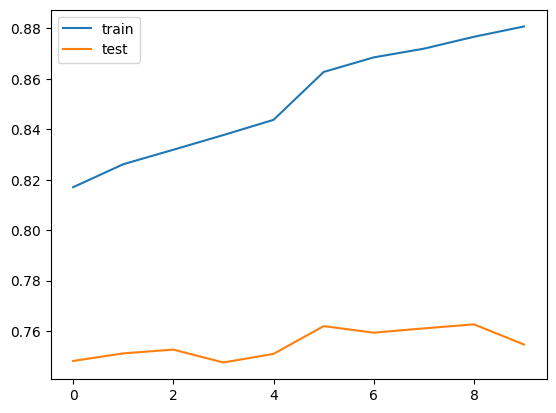

Training complete in 6m 7s
Best val Acc: 0.762700
[[793  13  54  23  20  14   6  17  59  30]
 [ 24 883   9  10   4   7   7   3  26  78]
 [ 39   4 662  62  74  49  38  31  11   6]
 [ 25   7  65 611  54 168  57  31  13   9]
 [ 14   0  79  53 711  36  33  36   4   2]
 [  5   3  51 129  26 645  20  56   3   5]
 [  5   3  41  56  35  21 828   5   4   3]
 [ 15   3  25  28  67  48   2 810   7  10]
 [ 46  16   7  10   6   5   2   3 846  19]
 [ 34  68   7  18   3   7   7   8  27 838]]


In [ ]:
from torch.optim import lr_scheduler

# The name of the dataset
tag = "simpleCNN_cifar_v1"
img_path = DATA_DIR

nlabel = 10

# create the network
net_cifar = SimpleCNN(n_in = 3, n_out=nlabel)

lr_start = 1e-2

# Read the last learned network (if stored)
try:
  if (os.path.exists(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))):
    print('Resume from last learning step')
    net_cifar = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
    try:
        lr = scheduler._last_lr[0]
    except NameError:
        lr = lr_start
except:
  print('Learn from scratch')
  net_cifar = SimpleCNN(n_in = 3, n_out=nlabel)
  lr = lr_start

net_cifar.to(device)

# Define optimization components (to be used in the learning function)


optimizer = torch.optim.Adam(net_cifar.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
#scheduler = None

# Learning
max_epoch = 10

learned_model, train_error, test_error, train_losses = \
train_model_multiclass(net_cifar, nlabel,
                        trainloader, testloader,
                        optimizer, scheduler,
                       num_epochs=max_epoch, display=True)

# Save last learned model
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

net_cifar = learned_model

# Evaluation
net_cifar.eval()

allpred = []
gt = []
with torch.no_grad():  ### no need to compute gradients
    for inputs, targets in testloader:
        inputs = inputs.to(device)
        outputs = net_cifar(inputs)
        _,pred = outputs.max(1)
        allpred += pred.cpu().numpy().tolist()
        gt += targets.cpu().numpy().tolist()

cm = confusion_matrix(allpred,gt,labels = list(range(nlabel)))
print(cm)

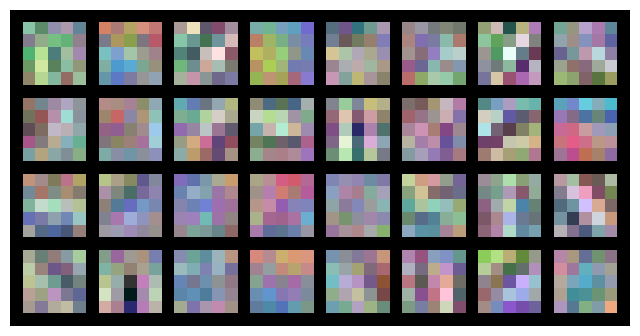

In [ ]:
# Visualization of the first convolution layer filters
from torchvision import utils
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

layer = 1
filter = net_cifar.conv1.weight.data.clone().cpu()
visTensor(filter, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.show()

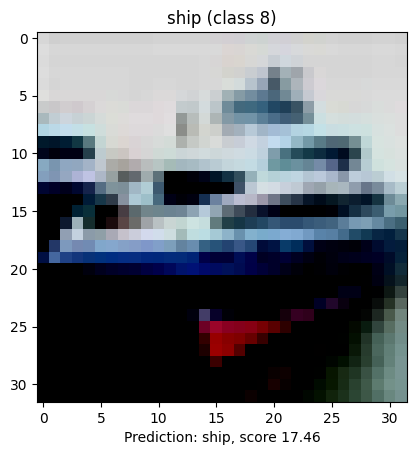

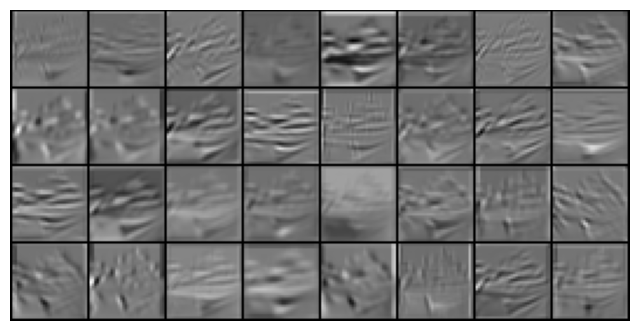

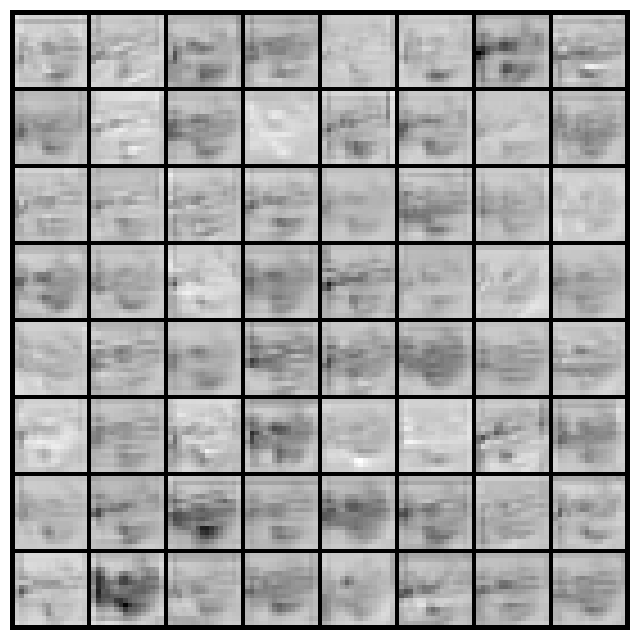

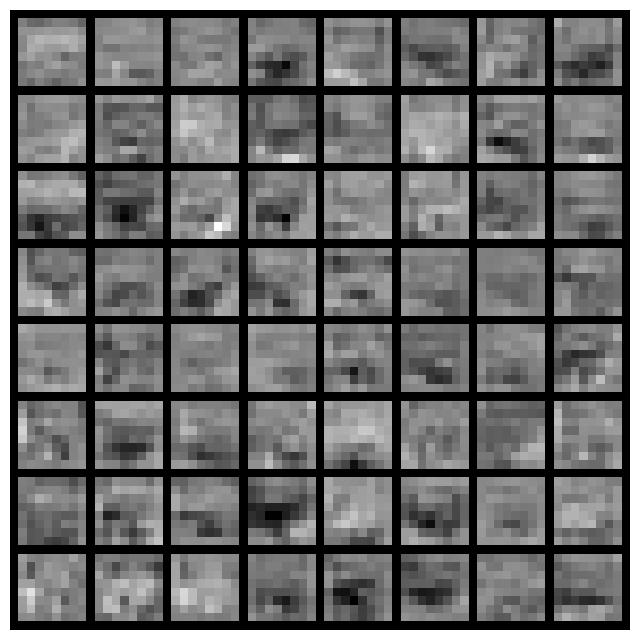

In [ ]:
# Little piece of code to export intermediate layer outputs
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model = net_cifar
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))

# Compute prediction for data isample
isample = 1

x = cifartest[isample]
itarget = x[1]
with torch.no_grad():
  output = model(x[0].to(device))
lt,ipred = output.max(1)
ipred = ipred.item()
lt = lt.item()

# Show isample mage
plt.imshow(x[0].permute(1, 2, 0))
plt.title(f"{class_names[itarget]} (class {itarget})")
plt.xlabel(f"Prediction: {class_names[ipred]}, score {lt:.2f}")
plt.show()

# Show the intermediate convolutional layer outputs
conv1_output = activation['conv1']
conv1_output=conv1_output.unsqueeze(1)
visTensor(conv1_output.cpu(), ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.show()

conv2_output = activation['conv2']
conv2_output=conv2_output.unsqueeze(1)
visTensor(conv2_output.cpu(), ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.show()

conv3_output = activation['conv3']
conv3_output=conv3_output.unsqueeze(1)
visTensor(conv3_output.cpu(), ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.show()

# Transfer learning

We study in this part the capacity of a network to transfer to another task. More precisely we are going to see if features learned on some dataset can help learning on another dataset.

Here, we will study the transfer from CIFAR10 (colorful images of objects) to SVHN (colorful house numbers), expecting that the good features extracted from objects are also good for colorful numbers.

## SVHN dataset

Run the following cell to upload the dataset and create the dataloaders.

Using downloaded and verified file: ./svhn/test_32x32.mat
Using downloaded and verified file: ./svhn/train_32x32.mat
torch.Size([256, 3, 32, 32])


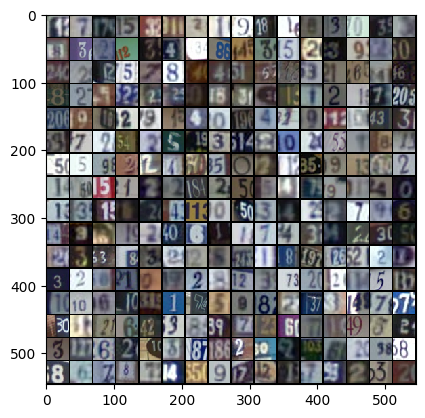

In [ ]:
transform_svhn = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

transform_test = v2.Compose([
    #v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

## Train and test are switched for faster computation
svhntrain = torchvision.datasets.SVHN("./svhn",split='test', transform=transform_svhn, download=True)
svhntest = torchvision.datasets.SVHN("./svhn",split='train', transform=transform_test, download=True)
trainloader = torch.utils.data.DataLoader(svhntrain, batch_size=256, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(svhntest, batch_size=256, shuffle=False, num_workers=2)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Display few samples
sample,targets = next(iter(trainloader))
show(torchvision.utils.make_grid(sample, nrow=16))
print(sample.shape)  ## 64 c'est le batch
                        ## 1 c'est du gris -- sinon ce serait 3 pour du RGB
                        ## 32x32 c'est pour la taille de l'image (petite ici)
plt.show()

## Learning strategy comparison

For transfer learning, we are going to load the network learned for CIFAR10 dataset, and change the last decision layer. We need to replace it by a layer with the good number of output neurons (here the $10$ digits).

For transfer learning there are two options:
- Learn only the last layer, assuming that the features are good
- Fine-tune the all network (features and last layer)

We want to compare the performance of these transfer learning strategies when using a single epoch for learning the new network.

<font color='red'>Question</font> Learn a new network starting from the network learned for the CIFAR10 dataset in the previous part updating the whole network.

<font color='red'>Question</font> Learn a new network starting from the network learned for the CIFAR10 dataset in the previous part updating only the last layer.

<font color='red'>Question</font> Learn a new network starting from scratch (random initilization).

<font color='red'>Question</font> Compare the performance of the three strategies.

You can make learning of each layer active or frozen by putting `requires_grad` to `True/False` for each parameter of `net.parameters()`.

In [ ]:
from torch.optim import lr_scheduler

tag_pretrained = tag
nlabel = 10

img_path = DATA_DIR

update = 'FT'
update = 'LAST'
update = 'SCRATCH'

for update in ['FT', 'LAST', 'SCRATCH']:
  ## Update the whole pre-trained network
  if update == 'FT':
    print(f'Fine tuning from pre-trained network {tag_pretrained}')
    tag = "simpleCNN_svhn_ft"

    # loads network learned from CIFAR10
    net_svhn = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag_pretrained)))

    # Replace the last layer
    net_svhn.final = nn.Linear(4096, nlabel)

  ## Update only the last layer
  elif update == 'LAST':
    print(f'Learn last layer from pre-trained network {tag_pretrained}')
    tag = "simpleCNN_svhn_last"

    # loads network learned from CIFAR10
    net_svhn = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag_pretrained)))

    # only allows last layer to be learned
    for param in net_svhn.parameters():
        param.requires_grad = False

    # Replace the last layer
    net_svhn.final = nn.Linear(4096, nlabel)

  ## Update from scratch
  else:
    print("Learning from scratch")
    # create the network
    tag = "simpleCNN_svhn_scratch"
    net_svhn = SimpleCNN(n_out=nlabel, n_in=3)

  net_svhn.to(device)

  # Define learning components (to be used in the learning function)
  optimizer = torch.optim.Adam(net_svhn.parameters(), lr=1e-3)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)

  # Learning
  max_epoch = 1

  learned_model, train_error, test_error, train_losses = \
  train_model_multiclass(net_svhn, nlabel,
                          trainloader, testloader,
                          optimizer, scheduler,
                          num_epochs=max_epoch, display=False)

  # Save last learned model
  torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))




train = 21.33%; val = 33.50%; loss = 2.176952e+00
Training complete in 1m 5s
Best val Acc: 0.334958


In [ ]:
accuracies = []
tags = ['simpleCNN_svhn_ft', 'simpleCNN_svhn_scratch', 'simpleCNN_svhn_last']
## Computes the performance of the three learning strategies
for tag in tags:
  net_svhn = torch.load(os.path.join(img_path, 'network_{:s}.pth'.format(tag)))
  # Evaluation
  net_svhn.eval()

  cm = np.zeros((nlabel,nlabel),dtype=int)
  with torch.no_grad():  ### no need to compute gradients
      for inputs, targets in tqdm(testloader, ncols=80):
          inputs = inputs.to(device)
          outputs = net_svhn(inputs)
          _,pred = outputs.max(1)
          cm += confusion_matrix(pred.cpu().numpy(),targets.cpu().numpy(),labels = list(range(nlabel)))
  accuracies.append(accuracy(cm))

print('\n')
for tag, acc in zip(tags, accuracies):
  print(f"Accuracy of {tag} = {100*acc:.1f}%")

100%|█████████████████████████████████████████| 287/287 [00:47<00:00,  6.09it/s]
<ipython-input-67-03d314cf999c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_svhn = 

Accuracy of simpleCNN_svhn_ft = 74.8%
Accuracy of simpleCNN_svhn_scratch = 33.5%
Accuracy of simpleCNN_svhn_last = 48.9%
